In [1]:
from board3 import Board3, sqr_distance
from controller3 import ActionController, MW_CELLS
import time
from heapq import heappush, heappop
from tqdm.auto import tqdm
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

from collections import Counter
from mcts import search
from nnl import to_emb, gather_history

In [2]:
board = Board3(walk_time=500)
board.set_player(1, 0)
board.set_enemy(2, 0)
board.set_todd(1, 2)
board.player_throw_mw(2, 1)
# board.swap_enemy()
board.step(2000)
# board.swap_enemy()
print(board)

.  %  .  %
P  %  T  %
E  #  .  .
.  .  .  .


In [3]:


start = time.time()
path = search(board, max_iterations=100000, time_step=1000)
if path:
    print(len(path))
print(f'Time: {time.time() - start}')

8
Time: 0.9639456272125244


In [4]:
for b, a in path:
    print(b)
    print(ActionController(b).explain_action(a))

.  %  .  %
P  %  T  %
E  #  .  .
.  .  .  .
Push E 3 0
.  %  .  %
P  %  .  %
.  #  T  .
E  .  .  .
Push T 3 3
.  %  .  %
.  %  .  %
P  #  T  .
E  .  .  O
Move 1 1
.  %  .  %
.  %  .  %
.  #  T  .
E  P  .  .
Push E 2 0
.  %  .  %
.  %  .  %
E  #  .  T
.  P  .  .
Push E 1 0
.  %  .  %
E  %  .  %
.  #  .  T
.  P  .  .
Move -1 -1
.  %  .  %
E  %  .  %
P  #  .  T
.  .  .  .
Push E 0 0
E  %  .  %
.  %  .  %
P  #  T  .
.  .  .  .
MW 1 0


In [17]:
sz = 2000
progress = tqdm(total=sz)
data = []
while len(data) < sz:
    board = Board3(walk_time=500)
    mwc = random.choice([0, 1])
    for _ in range(mwc):
        cl = random.choice(list(set(MW_CELLS) - {board.get_player_position(), board.get_enemy_position(), board.get_todd_position()}.union(board.mw)))
        board.add_mw(*cl)

    # data.append(board)
    path = search(board, 10000)
    if path is not None:
        eh = gather_history(path)
        data.extend(eh)
        progress.update(len(eh))

progress.close()


  0%|          | 0/2000 [00:00<?, ?it/s]

In [18]:
boards = []
histories = []
actions = []

for h in data:
    hl = []
    for b, a in h[:-1]:
        board_embedding = to_emb(b)
        action_embedding = nn.functional.one_hot(torch.LongTensor([a]), ActionController(b).get_action_space())
        hl.append(torch.cat([board_embedding, action_embedding], dim=1))
    hl = torch.cat(hl, dim=0).unsqueeze(0)
    be = to_emb(h[-1][0])
    boards.append(be)
    histories.append(hl)
    actions.append(h[-1][1])

boards = torch.cat(boards, dim=0)
histories = torch.cat(histories, dim=0)
actions = torch.LongTensor(actions)
print(boards.shape, histories.shape, actions.shape)
train_dataset = TensorDataset(boards, histories, actions)

torch.Size([2002, 22]) torch.Size([2002, 2, 60]) torch.Size([2002])


In [19]:
progress = tqdm(total=100)
data = []
while len(data) < 100:
    board = Board3(walk_time=500)
    # for _ in range(3):
    #     if random.random() < 0.3:
    #         board.add_mw(*random.choice(MW_CELLS))
    path = search(board, 1000)
    if path is not None:
        eh = gather_history(path)
        data.extend(eh)
        progress.update(len(eh))

progress.close()


boards = []
histories = []
actions = []

for h in data:
    hl = []
    for b, a in h[:-1]:
        board_embedding = to_emb(b)
        action_embedding = nn.functional.one_hot(torch.LongTensor([a]), ActionController(b).get_action_space())
        hl.append(torch.cat([board_embedding, action_embedding], dim=1))
    hl = torch.cat(hl, dim=0).unsqueeze(0)
    be = to_emb(h[-1][0])
    boards.append(be)
    histories.append(hl)
    actions.append(h[-1][1])

boards = torch.cat(boards, dim=0)
histories = torch.cat(histories, dim=0)
actions = torch.LongTensor(actions)
print(boards.shape, histories.shape, actions.shape)
test_dataset = TensorDataset(boards, histories, actions)

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 22]) torch.Size([100, 2, 60]) torch.Size([100])


In [20]:
mc = torch.zeros(4)
mv = torch.zeros(4)

for b, h, a in DataLoader(test_dataset, batch_size=32):
    mc[torch.sum(b[:, 6:] > 0, dim=1)] += len(b)


print(mc)

tensor([100.,   0.,   0.,   0.])


In [21]:
def eval_fc(dataset):
    mc = torch.zeros(4)
    mv = torch.zeros(4)
    fp.eval()
    correct = 0
    for b, h, a in DataLoader(dataset, batch_size=32):
        mc[torch.sum(b[:, 6:] > 0, dim=1)] += len(b)
        with torch.no_grad():
            y = fp(b, h).exp()
        mv[torch.sum(b[:, 6:] > 0, dim=1)] += (y.argmax(dim=-1) == a).sum()
    mc[mc == 0] = 1
    return mv / mc

Train: 2002, Test: 100


  0%|          | 0/400 [00:00<?, ?it/s]

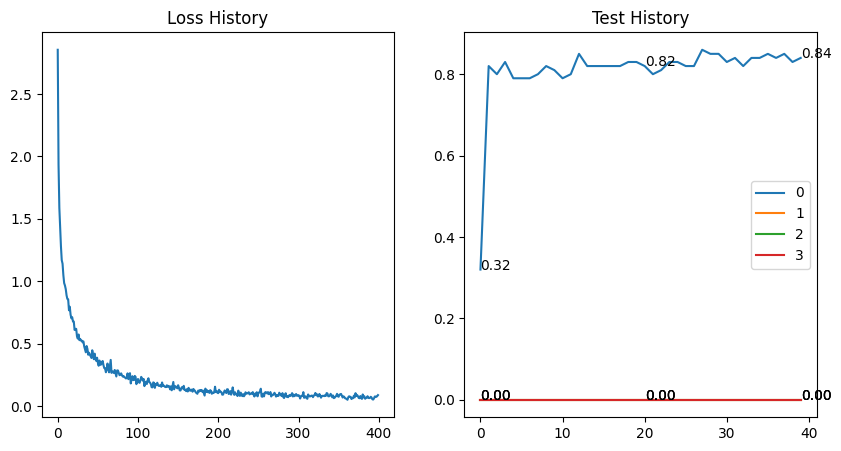

Lowers loss: 0.05. 0.86 0.00 0.00 0.00


In [22]:
class FP(nn.Module):
    def __init__(self, n_dim, a_space):
        super(FP, self).__init__()
        self.n_dim = n_dim
        self.a_space = a_space
        self.fc = nn.Sequential(
            nn.BatchNorm1d(n_dim),
            nn.Linear(n_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 256),

        )

        self.hf = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.BatchNorm1d(120),
            nn.Linear(120, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 256),
        )


        self.fe = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, a_space),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x, h):
        hidden = self.fc(x) + self.hf(h)
        return self.fe(hidden)



print(f'Train: {len(train_dataset)}, Test: {len(test_dataset)}')

b = Board3(walk_time=500)
x = to_emb(b)

fp = FP(x.shape[1], ActionController(b).get_action_space())

crit = nn.NLLLoss()
opt = optim.AdamW(fp.parameters(), lr=0.001)

lh = []
th = []
for e in tqdm(range(400)):
    el = []
    fp.train()
    for b, h, a in DataLoader(train_dataset, batch_size=32, shuffle=True):
        opt.zero_grad()
        y = fp(b, h)
        l = crit(y, a)
        l.backward()
        opt.step()
        el.append(l.item())
    lh.append(sum(el) / len(el))

    if e % 10 == 0:
        th.append(eval_fc(test_dataset))




# plot loss history and test history side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(lh)

ax[0].set_title('Loss History')


for l in zip(*th):
    ax[1].plot(l)

    for i in range(0, len(l), 20):
        ax[1].text(i, l[i], f'{l[i]:.2f}')

    ax[1].text(len(l) - 1, l[-1], f'{l[-1]:.2f}')

ax[1].set_title('Test History')
ax[1].legend(['0', '1', '2', '3'])
plt.show()


print(f'Lowers loss: {min(lh):.2f}.', ' '.join([f'{max(l):.2f}' for l in zip(*th)]))
